In [3]:
import sqlite3
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import networkx as nx
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
from common import detect_handovers,get_adjacent_files

In [11]:
def idplot(base, hops, _type, method, host=None):
    G = nx.Graph()
    g = {}
    for file in os.listdir(base):
        filename = os.fsdecode(file)
        if _type in filename and method in filename:
            with open(base + filename, "r") as csvfile:
                d = list(csv.reader(csvfile))
                for r in range(len(d) - (30 - hops)):
                    ip1 = d[r][2]
                    ip2 = d[r + 1][2]
                    effe = ["*", "ip"]
                    if ip1 not in effe and ip2 not in effe:
                        if ip1 not in g:
                            g[ip1] = []
                        if ip2 not in g[ip1]:
                            g[ip1].append(ip2)

    for k, v in g.items():
        G.add_node(k)
        for i in v:
            G.add_edge(k, i)

    return G

def draw(G):
    # _,degree = map(list, zip(*G.degree()))
    nx.draw_kamada_kawai(
        G,
        node_color=range(len(G.degree())),
        cmap=plt.cm.GnBu,
        # node_size=[(v * 500) + 1 for v in  degree],
        with_labels=True,
    )
def cloud_draw(provider, hops, method):
    plt.figure(figsize=(30, 30))
    plt.subplot(3, 2, 1)  # Define 3 rows, 2 column, Activate subplot 1.
    base = f"../idp-castellotti-data/traceroutes_cloud/{provider}/"
    # plt.subplot(321)
    # G = idplot(base=base, hops=8, _type="starlink", method=method)
    # draw(G)
    plt.subplot(322)
    G = idplot(base=base, hops=hops, _type="normal", method=method)
    draw(G)
    plt.show()
    


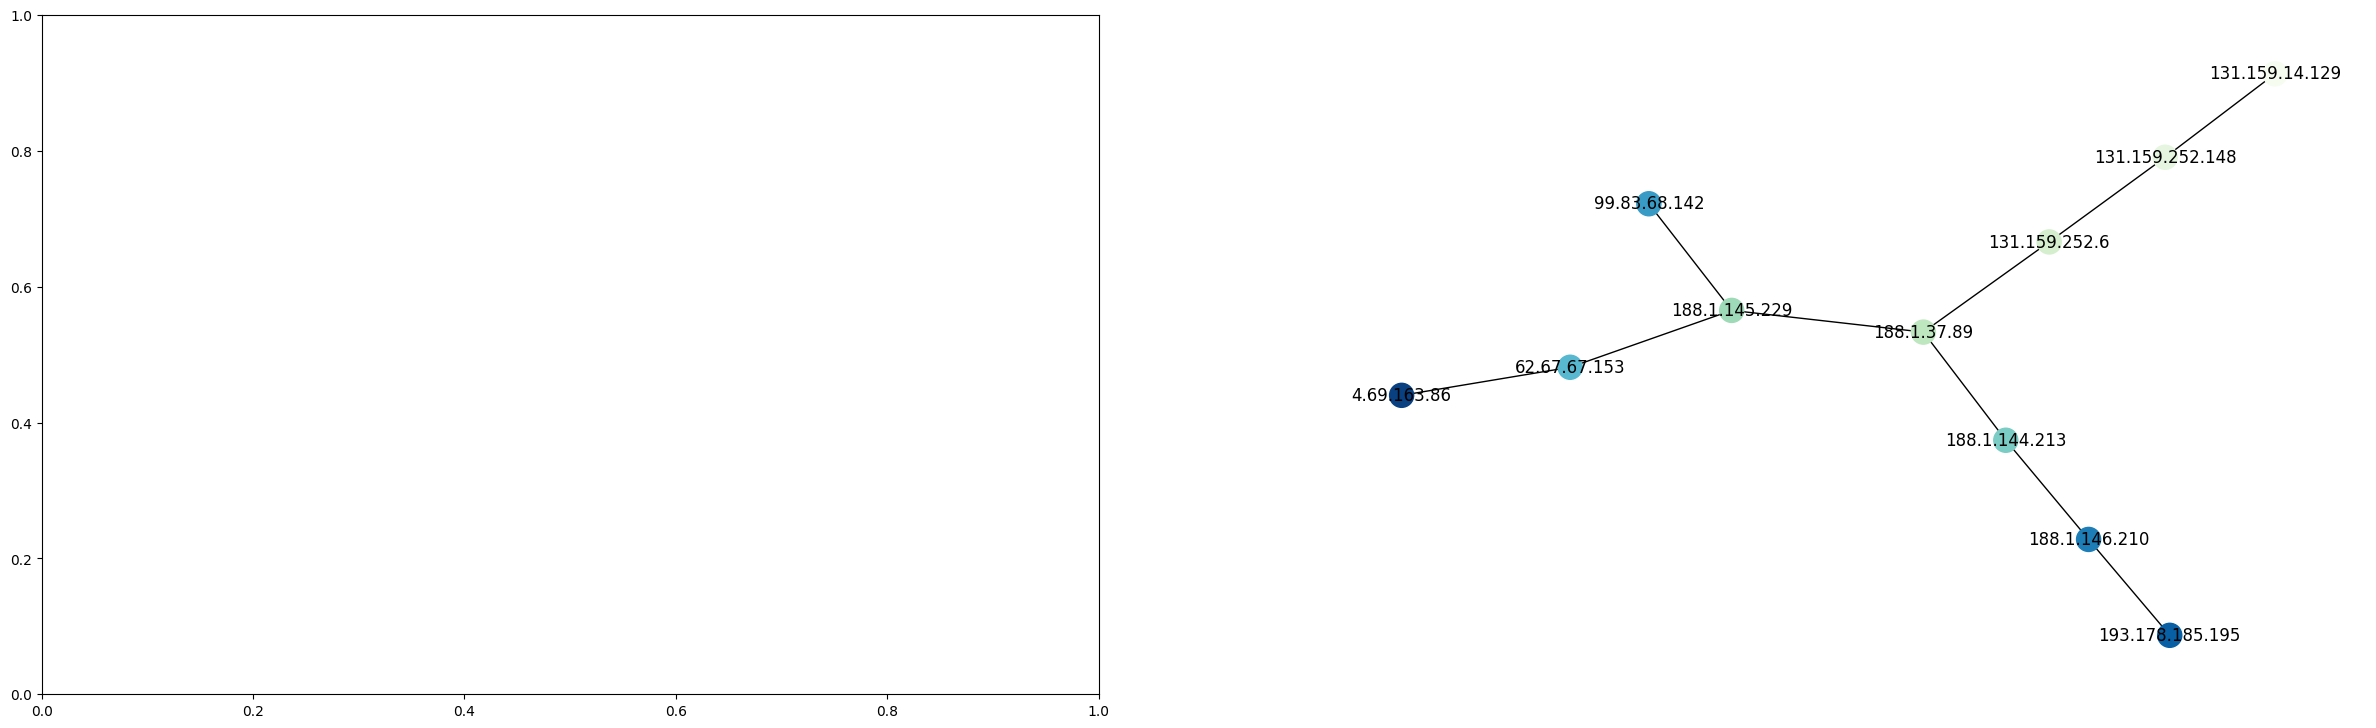

In [12]:
cloud_draw(provider="aws", hops=7, method="ICMP")

In [ ]:
cloud_draw(provider="aws", hops=7, method="UDP")

In [ ]:
cloud_draw(provider="aws", hops=7, method="TCP")

In [ ]:
cloud_draw(provider="azure", hops=7, method="ICMP")

In [ ]:
from common import calculate_visible_satellites

# garching coordinates
observer_latitude = 48.2489
observer_longitude = 11.6532
observer_elevation = 0

visible_satellites = calculate_visible_satellites(observer_latitude, observer_longitude, observer_elevation, distance_km=800)

for sat, alt, az in visible_satellites:
    print(sat.name)
    # print(f"Satellite: {sat}")
    # print(f"Altitude: {alt.degrees} degrees")
    # print(f"Azimuth: {az.degrees} degrees")

In [ ]:
df = pd.read_csv("../idp-castellotti-data/large_file_download_5parallel.csv")
# df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s', origin='unix')
plt.figure(figsize=(16,8))
sns.lineplot(data=df[100:], x="timestamp",y="pop_ping_latency_ms", dashes=True)
plt.show()


In [ ]:
df0 = pd.read_csv("../idp-castellotti-data/pli_normal.csv")
df1 = pd.read_csv("../idp-castellotti-data/pli_10k.csv")
df2 = pd.read_csv("../idp-castellotti-data/pli_20k.csv")
df3 = pd.read_csv("../idp-castellotti-data/pli_50k.csv")
df4 = pd.read_csv("../idp-castellotti-data/pli_100k.csv")
df5 = pd.read_csv("../idp-castellotti-data/pli_1M.csv")
df6 = pd.read_csv("../idp-castellotti-data/pli_10M.csv")
df = pd.concat([df0, df1, df2, df3, df4, df5, df6], axis=1).reindex(df1.index)
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=df[
        [
            "rtt",
            # "pop_ping_latency_ms",
            "rtt10k",
            # "pop_ping_latency_ms10k",
            "rtt20k",
            # "pop_ping_latency_ms20k",
            "rtt50k",
            # "pop_ping_latency_ms50k",
            "rtt100k",
            # "pop_ping_latency_ms100k",
            "rtt1M",
            # "pop_ping_latency_ms1M",
            "rtt10M",
            # "pop_ping_latency_ms10M",
        ]
    ],
    orient="h",
)
plt.xlabel("time (milliseconds)")
plt.show()

In [ ]:
df = pd.read_csv("../idp-castellotti-data/visible_satellites_variable_distance.csv")
plt.figure(figsize=(15, 8))
sns.countplot(x=df["distance"]).set_title("number of satellites")
plt.ylabel("# of satellites")
plt.xlabel("distance (km)")
plt.show()

In [ ]:
# satellites.sqlite is created from `patterns_in_satellite_appearances`
cnx = sqlite3.connect("../idp-castellotti-data/satellites.sqlite")
df = pd.read_sql("select * from satellites", cnx)
# df = df[:1000]
df["timestamp"] = pd.to_datetime(df["ts"], unit="s")
sns.countplot(df, x="relative_ts", dodge=False)
plt.xlabel("time intervals (15 seconds)")
plt.ylabel("# of visible satellites")
plt.title('count of visible satellites in 15 seconds intervals')
plt.gca().axes.xaxis.set_ticklabels([])
plt.plot()

In [ ]:
from skyfield.api import load, wgs84

stations_url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
satellites = load.tle_file(stations_url)
print("Loaded", len(satellites), "satellites")
by_name = {sat.name: sat for sat in satellites}
satellite = by_name["STARLINK-1007"]

# year, month, day, hour, minute, second
ts = load.timescale()
t = ts.now()
a = satellite.at(t)
lat, lon = wgs84.latlon_of(a)
print("Latitude:", lat)
print("Longitude:", lon)

In [ ]:
handover_unix_timestamps = []
directory_path = "../idp-castellotti-data/obstruction_maps"

for f in get_adjacent_files(directory_path):
    h=detect_handovers(
        os.path.join(directory_path, f[0]),
        os.path.join(directory_path, f[1]),
    )
    if h is not None:
        handover_unix_timestamps.append(h)


df = pd.read_csv("../idp-castellotti-data/obstruction_maps.csv")
plt.figure(figsize=(16, 8))
sns.lineplot(data=df, x="timestamp", y="downlink_troughput_bps", dashes=True)

for timestamp in handover_unix_timestamps:
    plt.axvline(x=timestamp, color="r", linestyle="--")

In [ ]:
def split_non_consequtive(data):
    data = iter(data)
    val = next(data)
    chunk = []
    try:
        while True:
            chunk.append(val)
            val = next(data)
            if val[0] != chunk[-1][0] + 1:
                yield chunk
                chunk = []
    except StopIteration:
        if chunk:
            yield chunk
            
cnx = sqlite3.connect("../idp-castellotti-data/satellites.sqlite")
satellites = cnx.execute("SELECT * FROM satellites limit 100000").fetchall()
sats = defaultdict(list)
for sat in satellites:
    sats[sat[3]].append([sat[1], round(sat[2]), sat[3]])

segments = defaultdict(list)
count = 0
for k in sats:
    if count == 10000:
        break
    count += 1
    for i in split_non_consequtive(sats[k]):
        segments[k].append(
            (datetime.fromtimestamp(i[0][1]), datetime.fromtimestamp(i[-1][1]))
        )


# we need data in this format: https://stackoverflow.com/a/12291380
plt.figure(figsize=(16, 8))
for y in segments:
    for seg in segments[y]:
        plt.plot(seg, [y, y])
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
# plt.ylabel("satname")
# plt.xlabel("time (each tick is one hour)")
# plt.title("visualizing patterns in satellites appearances")
# plt.savefig("/Users/rc/idp-castellotti/tex/tumbeamer/pics/patterns-in-satellite-appearances.pdf")
plt.plot()

In [ ]:
map = json.load(open("../idp-castellotti-data/obstruction_maps/1692089163.json"))
map = map["dishGetObstructionMap"]["snr"]
map = np.array(map).reshape(123, 123)
plt.imshow(map)
plt.show()

In [ ]:
df = pd.read_csv("../idp-castellotti-data/large_file_download_5parallel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[0:151], dashes=True)
for i in range(0, 151, 15):
    plt.axvline(i, color="red", linestyle="--")
plt.legend(loc='upper right')
plt.show()

In [ ]:
df = pd.read_csv("../idp-castellotti-data/large_file_download_5parallel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")

fig, axes = plt.subplots(2, 2, figsize=(18, 18))
plt.title("donwloading debian iso (5 mirrors)")

plot = sns.lineplot(data=df[0:150], dashes=True,ax=axes[0, 0])
for i in range(0, 151, 15):
    plot.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[150:300], dashes=True, ax=axes[0, 1])
for i in range(150, 301, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[300:450], dashes=True, ax=axes[1, 0])
for i in range(300, 451, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[450:600], dashes=True, ax=axes[1, 1])
for i in range(450, 601, 15):
    ax.axvline(i, color="red", linestyle="--")

plt.show()